### Face Recognition Attendance System - DEMO SCRIPT
# ---

In [10]:
### Cell 1: Instalasi (Jalankan sekali jika library belum terinstal) 🛠️
!pip install face_recognition opencv-python sqlalchemy python-dotenv pillow numpy matplotlib seaborn pandas

# Catatan: Library Flask, flask-cors (untuk server), tidak wajib diinstal di lingkungan Jupyter
# ini, karena kita akan langsung menguji fungsi backend-nya.

# ---

In [11]:
### Cell 2: Import Library 📚

import os
import base64
import numpy as np
import cv2
import face_recognition # WAJIB di-import di sini untuk fungsi register/recognize
from datetime import datetime
from sqlalchemy import create_engine, Column, Integer, String, DateTime, LargeBinary, ForeignKey
from sqlalchemy.orm import declarative_base, sessionmaker, relationship
from dotenv import load_dotenv
import io
from PIL import Image
import traceback
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load .env (opsional, tapi tetap dipertahankan untuk konsistensi)
load_dotenv()
print("Library berhasil di-import.")

# ---

Library berhasil di-import.


In [12]:
### Cell 3: Setup Database (SQLite) ⚙️

# Tentukan path database
BASE_DIR = os.path.dirname(os.path.abspath("")) # Menggunakan path relatif atau ubah sesuai kebutuhan
INSTANCE_DIR = os.path.join(BASE_DIR, 'instance')
os.makedirs(INSTANCE_DIR, exist_ok=True)

DATABASE_URL = f"sqlite:///{os.path.join(INSTANCE_DIR, 'attendance.db')}"
engine = create_engine(DATABASE_URL, echo=False) # echo=True jika ingin melihat query SQL
Base = declarative_base()
SessionLocal = sessionmaker(bind=engine)

print(f"Database disiapkan di: {DATABASE_URL}")

# ---

Database disiapkan di: sqlite:////home/lycus/Nourivex/TugasKuliah/UniPresence/instance/attendance.db


In [13]:
### Cell 4: Model Database 🧑‍ attendance

class User(Base):
    __tablename__ = 'users'
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String, nullable=False)
    student_id = Column(String, unique=True, nullable=False)
    face_encoding = Column(LargeBinary, nullable=False) # Menyimpan fitur wajah dalam bentuk biner
    created_at = Column(DateTime, default=datetime.utcnow)
    attendances = relationship("Attendance", back_populates="user")
    
    def __repr__(self):
        return f"<User(name='{self.name}', student_id='{self.student_id}')>"

class Attendance(Base):
    __tablename__ = 'attendance'
    id = Column(Integer, primary_key=True, autoincrement=True)
    student_id = Column(String, ForeignKey('users.student_id'), nullable=False)
    timestamp = Column(DateTime, default=datetime.utcnow)
    user = relationship("User", back_populates="attendances")
    
    def __repr__(self):
        return f"<Attendance(student_id='{self.student_id}', timestamp='{self.timestamp}')>"

# Buat tabel
Base.metadata.create_all(engine)
print("Tabel database berhasil dibuat/dicek.")

# ---

Tabel database berhasil dibuat/dicek.


In [14]:
### Cell 5: Fungsi Bantu: Dekode Base64 & Visualisasi 🖼️

def decode_base64_image(base64_string):
    """Mendekode string base64 menjadi numpy array (RGB)"""
    print("\n--- Mulai Dekode Citra ---")
    try:
        # Hapus prefix data URL jika ada
        if 'base64,' in base64_string:
            base64_string = base64_string.split('base64,')[1]
        
        # Dekode base64
        img_data = base64.b64decode(base64_string)
        print(f"Ukuran data biner: {len(img_data)/1024:.2f} KB")
        
        # Konversi ke PIL Image
        img = Image.open(io.BytesIO(img_data))
        print(f"Format asli PIL: {img.format}, Mode: {img.mode}, Ukuran: {img.size}")

        # Pastikan konversi ke RGB untuk face_recognition
        img_rgb = img.convert('RGB')
        
        # Konversi ke numpy array
        img_array = np.array(img_rgb)
        print(f"Numpy Array dibuat. Shape: {img_array.shape}, Dtype: {img_array.dtype}")
        print("--- Dekode Selesai ---")
        
        return img_array, None
    except Exception as e:
        error_msg = f"Error decoding image: {str(e)}"
        print(f"!!! GAGAL DEKODE: {error_msg} !!!")
        traceback.print_exc()
        return None, error_msg

def image_to_base64(image_path):
    """Bantu konversi file gambar ke base64 (untuk testing)"""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"File tidak ditemukan: {image_path}")
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

def draw_face_boxes(image_array, face_locations, title="Detected Faces"):
    """Menampilkan gambar dengan bounding box wajah"""
    img_copy = image_array.copy()
    # face_locations: (top, right, bottom, left)
    for (top, right, bottom, left) in face_locations:
        # Gambar kotak: (left, top) ke (right, bottom)
        cv2.rectangle(img_copy, (left, top), (right, bottom), (255, 0, 0), 2)
    
    plt.figure(figsize=(6, 4))
    plt.imshow(img_copy)
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_face_encoding(encoding, title="Face Encoding Vector"):
    """Visualisasi encoding wajah sebagai heatmap 1D"""
    plt.figure(figsize=(10, 1.5))
    # Face_recognition menghasilkan 128-dimensi vector
    sns.heatmap([encoding], cmap="viridis", cbar=True, xticklabels=False)
    plt.title(title)
    plt.xlabel(f"Feature Index (Total {len(encoding)} dimensi)")
    plt.yticks([])
    plt.show()

# ---

In [15]:
### Cell 6: Fungsi Registrasi (Logika /api/register) 👤+

def register_face(name: str, student_id: str, image_base64: str):
    """Logika pendaftaran wajah dan penyimpanan encoding ke DB."""
    print(f"\n--- Memulai Registrasi untuk: {name} ({student_id}) ---")
    
    img_array, decode_error = decode_base64_image(image_base64)
    if img_array is None:
        return {'status': 'error', 'message': f'Gagal memproses gambar: {decode_error}'}
    
    # 1. Deteksi Wajah
    face_locations = face_recognition.face_locations(img_array)
    print(f"Wajah terdeteksi: {len(face_locations)} lokasi.")

    if len(face_locations) == 0:
        return {'status': 'error', 'message': 'Wajah tidak terdeteksi.'}
    if len(face_locations) > 1:
        return {'status': 'error', 'message': 'Lebih dari satu wajah terdeteksi.'}
    
    # Visualisasi (Opsional)
    draw_face_boxes(img_array, face_locations, title=f"Wajah Terdeteksi: {name}")

    # 2. Ekstrak Encoding
    face_encodings = face_recognition.face_encodings(img_array, face_locations)
    if len(face_encodings) == 0:
        return {'status': 'error', 'message': 'Gagal mengekstrak fitur wajah.'}
    
    face_encoding = face_encodings[0]
    print(f"Encoding wajah berhasil diekstrak. Dimensi: {face_encoding.shape}, Dtype: {face_encoding.dtype}")
    # Visualisasi Encoding (Opsional)
    plot_face_encoding(face_encoding, title=f"Encoding Wajah: {name}")
    
    # 3. Simpan ke Database
    session = SessionLocal()
    try:
        existing_user = session.query(User).filter_by(student_id=student_id).first()
        if existing_user:
            print(f"NIM {student_id} sudah terdaftar. Pembatalan registrasi.")
            return {'status': 'error', 'message': f'NIM {student_id} sudah terdaftar.'}
        
        # Simpan encoding sebagai biner (bytes)
        new_user = User(
            name=name,
            student_id=student_id,
            face_encoding=face_encoding.tobytes() # numpy array diubah ke bytes
        )
        session.add(new_user)
        session.commit()
        print(f"Data user baru berhasil disimpan di DB. ID: {new_user.id}")
        return {'status': 'success', 'message': f'Wajah {name} berhasil terdaftar!'}
    except Exception as e:
        session.rollback()
        print(f"!!! GAGAL SIMPAN DATA: {str(e)} !!!")
        traceback.print_exc()
        return {'status': 'error', 'message': f'Gagal menyimpan data: {str(e)}'}
    finally:
        session.close()

# ---



In [16]:
### Cell 7: Fungsi Pengenalan & Absensi (Logika /api/recognize) 👁️

def recognize_face(image_base64: str):
    """Logika pengenalan wajah dan pencatatan absensi."""
    print("\n--- Memulai Proses Pengenalan Wajah dan Absensi ---")
    
    img_array, decode_error = decode_base64_image(image_base64)
    if img_array is None:
        return {'status': 'error', 'message': f'Gagal memproses gambar: {decode_error}', 'detected': False}
    
    # 1. Deteksi dan Ekstrak Encoding Wajah Unknown
    face_locations = face_recognition.face_locations(img_array)
    if len(face_locations) == 0:
        print("Wajah tidak terdeteksi di frame.")
        return {'status': 'error', 'message': 'Wajah tidak terdeteksi', 'detected': False}
    
    face_encodings = face_recognition.face_encodings(img_array, face_locations)
    if len(face_encodings) == 0:
        print("Gagal mengekstrak fitur wajah.")
        return {'status': 'error', 'message': 'Gagal mengekstrak fitur wajah', 'detected': False}
    
    unknown_encoding = face_encodings[0]
    print(f"Encoding wajah unknown berhasil diekstrak.")
    # Visualisasi Wajah Terdeteksi
    draw_face_boxes(img_array, face_locations, title="Wajah Unknown Terdeteksi")
    
    # 2. Ambil Semua User dari DB dan Bandingkan
    session = SessionLocal()
    try:
        users = session.query(User).all()
        
        if not users:
            print("Belum ada wajah terdaftar di DB.")
            return {'status': 'error', 'message': 'Belum ada wajah terdaftar', 'detected': False}
        
        for user in users:
            # Konversi bytes dari DB kembali ke numpy array (float64, harus sama dengan saat disimpan)
            known_encoding = np.frombuffer(user.face_encoding, dtype=np.float64)
            
            # Bandingkan wajah (tolerance=0.6 adalah nilai default)
            matches = face_recognition.compare_faces([known_encoding], unknown_encoding, tolerance=0.6)
            face_distance = face_recognition.face_distance([known_encoding], unknown_encoding)
            
            confidence = float(1 - face_distance[0])
            print(f"Membandingkan dengan {user.name} ({user.student_id}). Match: {matches[0]}, Confidence: {confidence:.2f}")

            if matches[0]:
                # Wajah Dikenali! Lanjut ke proses Absensi
                today = datetime.now().date()
                existing_attendance = session.query(Attendance).filter(
                    Attendance.student_id == user.student_id,
                    Attendance.timestamp >= datetime.combine(today, datetime.min.time())
                ).first()
                
                if existing_attendance:
                    print(f"Absensi untuk {user.name} sudah tercatat hari ini.")
                    return {
                        'status': 'success',
                        'message': 'Absensi sudah tercatat hari ini',
                        'name': user.name,
                        'student_id': user.student_id,
                        'already_marked': True,
                        'detected': True,
                        'confidence': confidence
                    }
                
                # Catat Absensi Baru
                new_attendance = Attendance(student_id=user.student_id)
                session.add(new_attendance)
                session.commit()
                print(f"Absensi baru dicatat untuk {user.name} pada {datetime.now().isoformat()}")
                
                return {
                    'status': 'success',
                    'message': 'Absensi berhasil dicatat',
                    'name': user.name,
                    'student_id': user.student_id,
                    'already_marked': False,
                    'detected': True,
                    'confidence': confidence,
                    'timestamp': datetime.now().isoformat()
                }
        
        # Tidak ada kecocokan setelah semua user di-loop
        print("Wajah tidak cocok dengan user terdaftar manapun.")
        return {'status': 'error', 'message': 'Wajah tidak dikenali', 'detected': False}
    
    except Exception as e:
        session.rollback()
        print(f"!!! ERROR PADA PROSES RECOGNIZE/ABSENSI: {str(e)} !!!")
        traceback.print_exc()
        return {'status': 'error', 'message': f'Error: {str(e)}', 'detected': False}
    finally:
        session.close()

# ---

In [17]:
### Cell 8: Fungsi Tambahan: Get Data (Debugging) 📊

def get_all_users():
    session = SessionLocal()
    try:
        users = session.query(User).all()
        return pd.DataFrame([
            {'id': u.id, 'name': u.name, 'student_id': u.student_id, 'created_at': u.created_at.isoformat()} 
            for u in users
        ])
    finally:
        session.close()

def get_all_attendance():
    session = SessionLocal()
    try:
        attendances = session.query(Attendance).join(User).order_by(Attendance.timestamp.desc()).all()
        return pd.DataFrame([
            {
                'id': a.id,
                'name': a.user.name,
                'student_id': a.student_id,
                'timestamp': a.timestamp.isoformat()
            } for a in attendances
        ])
    finally:
        session.close()

# ---

Gambar demo berhasil dikonversi ke Base64.

UJI 1: REGISTRASI

--- Memulai Registrasi untuk: Lycus Aja (191001) ---

--- Mulai Dekode Citra ---
Ukuran data biner: 718.80 KB
Format asli PIL: JPEG, Mode: RGB, Ukuran: (1385, 2048)
Numpy Array dibuat. Shape: (2048, 1385, 3), Dtype: uint8
--- Dekode Selesai ---
Wajah terdeteksi: 1 lokasi.


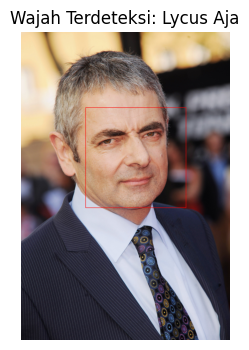

Encoding wajah berhasil diekstrak. Dimensi: (128,), Dtype: float64


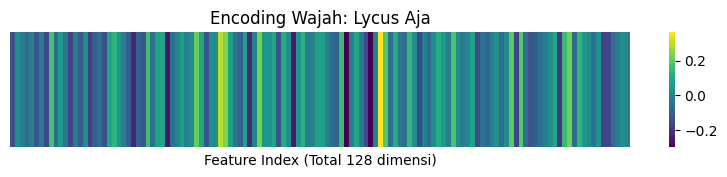

NIM 191001 sudah terdaftar. Pembatalan registrasi.

[HASIL REGISTRASI]:
{'status': 'error', 'message': 'NIM 191001 sudah terdaftar.'}


In [21]:

### Cell 9: DEMO PENGUJIAN 🧪

# ⚠️ GANTI DENGAN PATH GAMBAR ASLI DI KOMPUTER-mu
# Kamu perlu siapkan minimal 2 file gambar: satu untuk registrasi, satu untuk recognition/absensi
# Contoh: 'lycus_register.jpg' dan 'lycus_absensi.jpg'
REGISTER_IMAGE_PATH = 'lycus_register.jpg' 
RECOGNIZE_IMAGE_PATH = 'party.jpg' 

# 1. Pastikan file gambar ada
try:
    base64_reg_img = image_to_base64(REGISTER_IMAGE_PATH)
    base64_rec_img = image_to_base64(RECOGNIZE_IMAGE_PATH)
    print("Gambar demo berhasil dikonversi ke Base64.")
except FileNotFoundError as e:
    print(f"\n--- PENTING: GAGAL UJI ---")
    print(e)
    print("Silakan ganti path di Cell 9 dengan lokasi gambar yang valid.")
    base64_reg_img = None
    base64_rec_img = None

if base64_reg_img and base64_rec_img:
    # --- Uji 1: Registrasi User Baru ---
    print("\n" + "="*50)
    print("UJI 1: REGISTRASI")
    print("="*50)
    
    # Hati-hati: Jika NIM sudah ada, akan gagal. Hapus DB atau ganti NIM jika gagal.
    REG_NIM = "191001"
    REG_NAME = "Lycus Aja"
    
    reg_result = register_face(REG_NAME, REG_NIM, base64_reg_img)
    print("\n[HASIL REGISTRASI]:")
    print(reg_result)



UJI 2: CEK DATA USER
   id       name student_id                  created_at
0   1  Lycus Aja     191001  2025-10-13T12:59:44.944611

UJI 3: ABSENSI PERTAMA

--- Memulai Proses Pengenalan Wajah dan Absensi ---

--- Mulai Dekode Citra ---
Ukuran data biner: 136.80 KB
Format asli PIL: JPEG, Mode: RGB, Ukuran: (1500, 1125)
Numpy Array dibuat. Shape: (1125, 1500, 3), Dtype: uint8
--- Dekode Selesai ---
Encoding wajah unknown berhasil diekstrak.


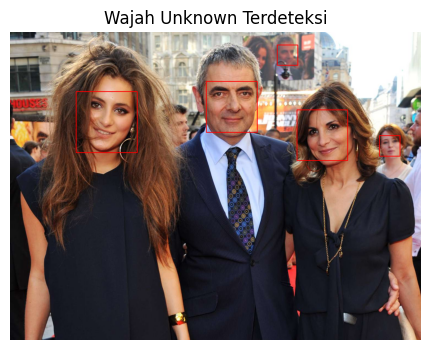

Membandingkan dengan Lycus Aja (191001). Match: True, Confidence: 0.72
Absensi untuk Lycus Aja sudah tercatat hari ini.

[HASIL ABSENSI PERTAMA]:
{'status': 'success', 'message': 'Absensi sudah tercatat hari ini', 'name': 'Lycus Aja', 'student_id': '191001', 'already_marked': True, 'detected': True, 'confidence': 0.7196273266284348}


In [22]:
    # --- Uji 2: Cek Data User di DB ---
    print("\n" + "="*50)
    print("UJI 2: CEK DATA USER")
    print("="*50)
    df_users = get_all_users()
    print(df_users)
    
    # --- Uji 3: Recognition/Absensi PERTAMA ---
    print("\n" + "="*50)
    print("UJI 3: ABSENSI PERTAMA")
    print("="*50)
    
    rec_result_1 = recognize_face(base64_rec_img)
    print("\n[HASIL ABSENSI PERTAMA]:")
    print(rec_result_1)


UJI 4: ABSENSI KEDUA (Cek Already Marked)

--- Memulai Proses Pengenalan Wajah dan Absensi ---

--- Mulai Dekode Citra ---
Ukuran data biner: 136.80 KB
Format asli PIL: JPEG, Mode: RGB, Ukuran: (1500, 1125)
Numpy Array dibuat. Shape: (1125, 1500, 3), Dtype: uint8
--- Dekode Selesai ---
Encoding wajah unknown berhasil diekstrak.


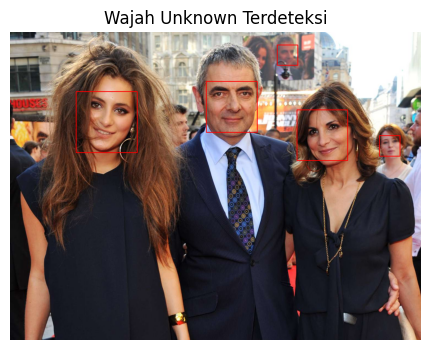

Membandingkan dengan Lycus Aja (191001). Match: True, Confidence: 0.72
Absensi untuk Lycus Aja sudah tercatat hari ini.

[HASIL ABSENSI KEDUA]:
{'status': 'success', 'message': 'Absensi sudah tercatat hari ini', 'name': 'Lycus Aja', 'student_id': '191001', 'already_marked': True, 'detected': True, 'confidence': 0.7196273266284348}

UJI 5: CEK DATA ABSENSI
   id       name student_id                   timestamp
0   1  Lycus Aja     191001  2025-10-13T12:59:45.075387


In [23]:
    # --- Uji 4: Recognition/Absensi KEDUA (Cek Already Marked) ---
    print("\n" + "="*50)
    print("UJI 4: ABSENSI KEDUA (Cek Already Marked)")
    print("="*50)

    rec_result_2 = recognize_face(base64_rec_img)
    print("\n[HASIL ABSENSI KEDUA]:")
    print(rec_result_2)
    
    # --- Uji 5: Cek Data Absensi di DB ---
    print("\n" + "="*50)
    print("UJI 5: CEK DATA ABSENSI")
    print("="*50)
    df_attendance = get_all_attendance()
    print(df_attendance)